_Author: Stephen Carr_

In [ ]:
using DMRJtensor
include("su2_tools.jl");

In [2]:
# setup spin 1/2 model
spinmag = 0.5;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag);

In [4]:
# XY model

tar_var = 1 # 1: Δ, 2: Sz, 3: Sx

J = -1;
onsite_op = O
if (tar_var == 2)
    onsite_op = Sz
elseif (tar_var == 3)
    onsite_op = Sx
end

H_n = [Id O O O
       J*Sx O O O
       J*Sy O O O
       O  Sx Sy Id];
# edge magnetic field
h = 1.0;
if (tar_var == 1)
   h = 0.0; 
end
hL = h
hR = -h # opposite sign for Sz
if tar_var == 3
   hR = h #  same sign for Sx
end
H_left = [Id O O O
          J*Sx O O O
          J*Sy O O O
          hL*onsite_op Sx Sy Id]

H_right = [Id O O O
          J*Sx O O O
          J*Sy O O O
          hR*onsite_op Sx Sy Id];


L_list = 4:4:32
var_arr = []
target_arr = []

for L = L_list  # number of sites
    H_op = Array{ComplexF64,2}[H_n for n =  1:L]
    H_op[1] = H_left
    H_op[L] = H_right
    H_mpo = makeMPO(H_op,size(Id,1),L); # make the MPO!
    psi = makePsi0(spinmag,L);
    
    # DMRG sweeps, with refinement 
    nsweeps_m40 = 20
    nsweeps_m128 = 10
    for i in 1:nsweeps_m40
        dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-4)
    end
    println("coarse run completed")
    for i in 1:nsweeps_m128
        dmrg(psi, H_mpo, maxm = 128, cutoff = 1E-10)
    end
    println("intermediate run completed")
    #for i in 1:nsweeps_m80
    #    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
    #end
    #println("fine run completed")
    variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
    println("L=", L)
    println("var=",abs(variance))
    push!(var_arr,abs(variance))
    
    center = Int64(L/2)

    Id_onesite_Sj = Id
    Id_onesite_dimer = [Id O O O 
                         O O O O
                         O O O O
                         O O O Id]
    dimer_op_L =        [Id O O O 
                         O O O O
                         O O O O
                         O Sx Sy Id]
    dimer_op_R =        [Id O O O 
                         Sx O O O
                         Sy O O O
                         O O O Id]

    # + term in dimer formula, at site [center+1]
    if (tar_var == 1)
        dimer_p = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
        dimer_p[center] = dimer_op_L
        dimer_p[center+1] = dimer_op_R
        dimer_m = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
        dimer_m[center-1] = dimer_op_L
        dimer_m[center] = dimer_op_R    

        dimer_p_mpo = makeMPO(dimer_p,size(Id,1),L);
        dimer_m_mpo = makeMPO(dimer_m,size(Id,1),L);

        Δ_p = expect(psi,dimer_p_mpo)
        Δ_m = expect(psi,dimer_m_mpo)
        Δ = (-1)^(center-1)*(Δ_p - Δ_m)
        println("Δ = ",Δ)
        push!(target_arr,Δ)
    elseif (tar_var == 2)       
        Sz_center = Array{ComplexF64,2}[Id_onesite_Sj for n =  1:L]
        Sz_center[center] = Sz
        Sz_mpo = makeMPO(Sz_center,size(Id,1),L); # make the MPO!
        Sz_c = expect(psi,Sz_mpo)
        println("Sz(L/2)=", real(Sz_c))
        push!(target_arr,Sz_c)
    elseif (tar_var == 3)
        Sx_center = Array{ComplexF64,2}[Id_onesite_Sj for n =  1:L]
        Sx_center[center] = Sx
        Sx_mpo = makeMPO(Sx_center,size(Id,1),L); # make the MPO!
        Sx_c = expect(psi,Sx_mpo)
        println("Sx(L/2)=", real(Sx_c))
        push!(target_arr,Sx_c)
    end
    
end

coarse run completed
intermediate run completed
L=4
var=2.3314686821363247e-13
Δ = 0.22360679525575847 - 1.3877787807814457e-17im
coarse run completed
intermediate run completed
L=8
var=6.838977376568934e-14
Δ = 0.11467653625289487 - 3.469446951953614e-18im
coarse run completed
intermediate run completed
L=12
var=7.328573303771489e-10
Δ = 0.07807415034213849 + 1.1926223897340549e-17im
coarse run completed
intermediate run completed
L=16
var=1.5272192399612366e-9
Δ = 0.05933295082938678 - 2.0816681711721685e-17im
coarse run completed
intermediate run completed
L=20
var=1.738420962748321e-9
Δ = 0.047887973904046977 + 4.163336342344337e-17im
coarse run completed
intermediate run completed
L=24
var=2.489848327705359e-9
Δ = 0.04015894199720804 - 1.457167719820518e-16im
coarse run completed
intermediate run completed
L=28
var=3.4427642964116937e-9
Δ = 0.034584353745491514 + 1.0408340855860843e-16im
coarse run completed
intermediate run completed
L=32
var=4.394777875020366e-9
Δ = 0.0303718996

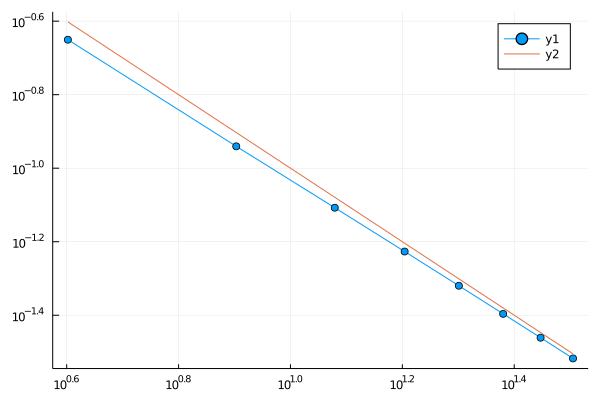

In [5]:
# plot <var> vs L, log-log
using Plots

plot(L_list,broadcast(abs,target_arr), marker=:circle,xaxis=:log, yaxis=:log)

if (tar_var == 3)
    plot!(L_list,L_list.^(-1/4),xaxis=:log,yaxis=:log)    
else
    plot!(L_list,L_list.^(-1),xaxis=:log,yaxis=:log)    
end

#plot(L_list,broadcast(abs,Sz_arr), marker=:circle, xaxis=:log, yaxis=:log,label="Sz")
#plot!(L_list,L_list.^(-1),xaxis=:log,yaxis=:log)

#plot(broadcast(abs,Sx_arr),marker=:circle,xaxis=:log,yaxis=:log)
#plot!(L_list,L_list.^(-1/4),xaxis=:log,yaxis=:log)

In [482]:
# XXZ model

tar_var = 1 # 1: Δ, 2: Sz, 3: Sx
γ = 1.0;
J = 1;

onsite_op = O
if (tar_var == 2)
    onsite_op = Sz
elseif (tar_var == 3)
    onsite_op = Sx
end

H_n = [    Id  O  O  O  O
         J*Sx  O  O  O  O
         J*Sy  O  O  O  O
       J*γ*Sz  O  O  O  O
            O Sx Sy Sz Id];
# edge magnetic field
h = 1.0;
if (tar_var == 1)
   h = 0.0; 
end
hL = h
hR = -h # opposite sign for Sz
if tar_var == 3
   hR = h #  same sign for Sx
end
H_left = [    Id  O  O  O  O
            J*Sx  O  O  O  O
            J*Sy  O  O  O  O
          J*γ*Sz  O  O  O  O
            hL*onsite_op Sx Sy Sz Id];

H_right = [   Id  O  O  O  O
            J*Sx  O  O  O  O
            J*Sy  O  O  O  O
          J*γ*Sz  O  O  O  O
            hR*onsite_op Sx Sy Sz Id];


L_list = 4:4:32
var_arr = []
target_arr = []

for L = L_list  # number of sites
    H_op = Array{ComplexF64,2}[H_n for n =  1:L]
    H_op[1] = H_left
    H_op[L] = H_right
    H_mpo = makeMPO(H_op,size(Id,1),L); # make the MPO!
    psi = makePsi0(spinmag,L);
    
    # DMRG sweeps, with refinement 
    nsweeps_m40 = 20
    nsweeps_m128 = 10

    for i in 1:nsweeps_m40
        dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-4)
    end
    println("coarse run completed")
    for i in 1:nsweeps_m128
        dmrg(psi, H_mpo, maxm = 128, cutoff = 1E-10)
    end
    println("intermediate run completed")
    #for i in 1:nsweeps_m80
    #    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
    #end
    #println("fine run completed")
    variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
    println("L=", L)
    println("var=",abs(variance))
    push!(var_arr,abs(variance))
    
    center = Int64(L/2)

    Id_onesite_Sj = Id
    Id_onesite_dimer = [Id O O O 
                         O O O O
                         O O O O
                         O O O Id]
    dimer_op_L =        [Id O O O 
                         O O O O
                         O O O O
                         O Sx Sy Id]
    dimer_op_R =        [Id O O O 
                         Sx O O O
                         Sy O O O
                         O O O Id]

    # + term in dimer formula, at site [center+1]
    if (tar_var == 1)
        dimer_p = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
        dimer_p[center] = dimer_op_L
        dimer_p[center+1] = dimer_op_R
        dimer_m = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
        dimer_m[center-1] = dimer_op_L
        dimer_m[center] = dimer_op_R    

        dimer_p_mpo = makeMPO(dimer_p,size(Id,1),L);
        dimer_m_mpo = makeMPO(dimer_m,size(Id,1),L);

        Δ_p = expect(psi,dimer_p_mpo)
        Δ_m = expect(psi,dimer_m_mpo)
        Δ = (-1)^(center-1)*(Δ_p - Δ_m)
        println("Δ = ",Δ)
        push!(target_arr,Δ)
    elseif (tar_var == 2)       
        Sz_center = Array{ComplexF64,2}[Id_onesite_Sj for n =  1:L]
        Sz_center[center] = Sz
        Sz_mpo = makeMPO(Sz_center,size(Id,1),L); # make the MPO!
        Sz_c = expect(psi,Sz_mpo)
        println("Sz(L/2)=", real(Sz_c))
        push!(target_arr,Sz_c)
    elseif (tar_var == 3)
        Sx_center = Array{ComplexF64,2}[Id_onesite_Sj for n =  1:L]
        Sx_center[center] = Sx
        Sx_mpo = makeMPO(Sx_center,size(Id,1),L); # make the MPO!
        Sx_c = expect(psi,Sx_mpo)
        println("Sx(L/2)=", real(Sx_c))
        push!(target_arr,Sx_c)
    end
    
end

coarse run completed
intermediate run completed
L=4
var=9.2592624859648e-13
Δ = -0.2886751447213074 + 2.7755575615628914e-17im
coarse run completed
intermediate run completed
L=8
var=7.10737795229831e-15
Δ = -0.18543175553071986 - 1.3877787807814457e-17im
coarse run completed
intermediate run completed
L=12
var=4.474358661390188e-10
Δ = -0.14498499569667156 + 3.469446951953614e-17im
coarse run completed
intermediate run completed
L=16
var=2.127102050056476e-9
Δ = -0.12195486732348745 + 6.938893903907228e-18im
coarse run completed
intermediate run completed
L=20
var=3.4098235346492897e-9
Δ = -0.10668548597778374 + 5.551115123125783e-17im
coarse run completed
intermediate run completed
L=24
var=5.031253636227666e-9
Δ = -0.09565551685342444 - 9.020562075079397e-17im
coarse run completed
intermediate run completed
L=28
var=6.995236390226155e-9
Δ = -0.08723214719555517 + 4.662069341687669e-17im
coarse run completed
intermediate run completed
L=32
var=7.902428934570741e-9
Δ = -0.080542436776

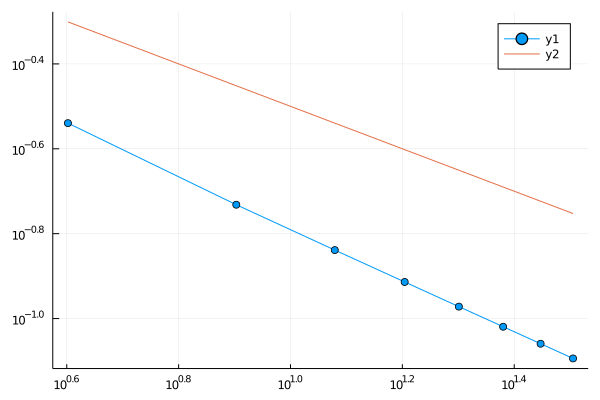

In [484]:
# plot <var> vs L, log-log
using Plots

plot(L_list,broadcast(abs,target_arr), marker=:circle,xaxis=:log, yaxis=:log)

if (tar_var == 3)
    plot!(L_list,L_list.^(-1/4),xaxis=:log,yaxis=:log)    
else
    plot!(L_list,(L_list).^(-1/2),xaxis=:log,yaxis=:log)    
end
#plot(L_list,broadcast(abs,Sz_arr), marker=:circle, xaxis=:log, yaxis=:log,label="Sz")
#plot!(L_list,L_list.^(-1),xaxis=:log,yaxis=:log)

#plot(broadcast(abs,Sx_arr),marker=:circle,xaxis=:log,yaxis=:log)
#plot!(L_list,L_list.^(-1/4),xaxis=:log,yaxis=:log)

coarse run completed
intermediate run completed
L=16
var=2.624486867830456e-7


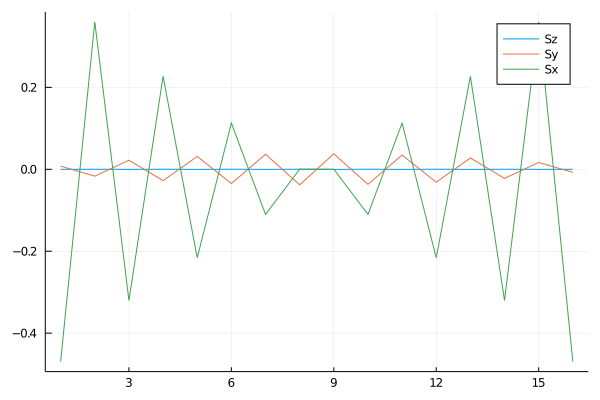

In [495]:
# Check field dependence of <S_i>

# XY model
J = 1;
H_n = [Id O O O
       J*Sx O O O
       J*Sy O O O
       O  Sx Sy Id];
# edge magnetic field
h = 1.0;
H_left = [Id O O O
          J*Sx O O O
          J*Sy O O O
          h*Sx Sx Sy Id]

H_right = [Id O O O
          J*Sx O O O
          J*Sy O O O
          h*Sx Sx Sy Id];


L = 16
Sx_arr = []
Sy_arr = []
Sz_arr = []

H_op = Array{ComplexF64,2}[H_n for n =  1:L]
H_op[1] = H_left
H_op[L] = H_right
H_mpo = makeMPO(H_op,size(Id,1),L); # make the MPO!
psi = makePsi0(spinmag,L);

# DMRG sweeps, with refinement 
nsweeps_m40 = 10
nsweeps_m128 = 80

for i in 1:nsweeps_m40
    dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-4)
end
println("coarse run completed")
for i in 1:nsweeps_m128
    dmrg(psi, H_mpo, maxm = 128, cutoff = 1E-14)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("L=", L)
println("var=",abs(variance))
    
for tar_site = 1:L
    Id_onesite = Id

    # + term in dimer formula, at site [center+1]
    Sz_op = Sz;
    Sx_op = Sx;
    Sy_op = Sy;
    
    Sz_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sz_h[tar_site] = Sz_op
    Sx_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sx_h[tar_site] = Sx_op
    Sy_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sy_h[tar_site] = Sy_op
    
    Sz_mpo = makeMPO(Sz_h,size(Id,1),L); # make the MPO!
    Sz_val = expect(psi,Sz_mpo)
    push!(Sz_arr,real(Sz_val))
    
    Sx_mpo = makeMPO(Sx_h,size(Id,1),L); # make the MPO!
    Sx_val = expect(psi,Sx_mpo)
    push!(Sx_arr,real(Sx_val))
    
    Sy_mpo = makeMPO(Sy_h,size(Id,1),L); # make the MPO!
    Sy_val = expect(psi,Sy_mpo)
    push!(Sy_arr,real(Sy_val))
    
end

plot(Sz_arr,label="Sz")
plot!(Sy_arr,label="Sy")
plot!(Sx_arr,label="Sx")

Any[-0.4690386275890707, 0.3596176787953757, -0.32033036398378767, 0.22710170161302803, -0.21594508598738993, 0.11285285454991327, -0.11015063261190781, 0.00023556387119989352, 0.00023559771291301436, -0.11015066675711548, 0.11285288221604017, -0.21594510685904073, 0.22710171905480311, -0.3203303777708173, 0.35961768521735865, -0.4690386285417974]


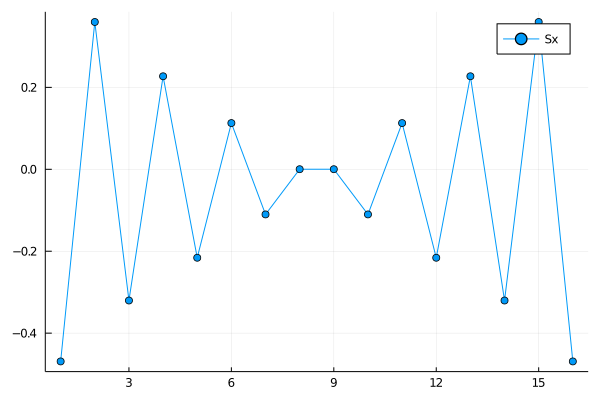

In [496]:
println(Sx_arr)
plot(Sx_arr,label="Sx",marker=:circle)
#plot!(Sy_arr,label="Sy")


In [487]:
tar_site = 3;
println(H_mpo[tar_site])
mpo_dims = H_mpo[tar_site].size
mpo_mat = H_mpo[tar_site].T


println(mpo_dims) # has indices [a1,s1,s2,a2]
for a1 = 1:mpo_dims[1] # major row
    for s1= 1:mpo_dims[2] # minor row
        for a2 = 1:mpo_dims[4] # major col
            for s2 = 1:mpo_dims[3] # minor col
                idx_h = a1 + (s1-1)*mpo_dims[1] + (s2-1)*mpo_dims[1]*mpo_dims[2] + (a2-1)*mpo_dims[1]*mpo_dims[2]*mpo_dims[3]

                print(round((mpo_mat[idx_h]),digits=1))
                print(" ")
            end
            print("| ")
        end
        print("\n")
    end
    for row_sep = 1:(mpo_dims[3]*mpo_dims[4])
        print("----")
    end
    print("\n")
end

printing regular tensor of type: tens{Complex{Float64}}
size = (5, 2, 2, 5)
T = Complex{Float64}[1.0 + 0.0im, 0.0 + 0.0im, 0.0 - 0.0im, 0.5 + 0.0im]...

(5, 2, 2, 5)
1.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 
0.0 + 0.0im 1.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 
----------------------------------------
0.0 + 0.0im 0.5 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 
0.5 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 
----------------------------------------
0.0 - 0.0im 0.0 - 0.5im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 
-0.0 + 0.5im 0.0 - 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 0.0im | 0.0 + 0.0im 0.0 + 

In [285]:
#println(Sx)
println(H_op[1])
n = convert(Int64,sqrt(length(H_op[1])))
for r = 1:n
    for c = 1:n
        idx = (c-1)*n + r
        print(abs(H_op[1][idx]), " ")
    end
    print("\n")
end

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0 + 0.0im -0.5 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.5 + 0.0im -0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0 + 0.0im -0.0 + 0.5im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.5im -0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 5.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.5 + 0.0im 0.0 - 0.0im 0.0 - 0.5im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -5.0 + 0.0im 0.5 + 0.0im 0.0 + 0.0im -0.0 + 0.5im 0.0 - 0.0im 0.0 + 0.0im 1.0 + 0.0im]
1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 
0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 
0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
